In [2]:
import numpy as np
%matplotlib inline
from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator, ConditionalDimension, Buffer, Constant
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver
import matplotlib.pyplot as plt

In [3]:
dim = 2
shape = (201, 201)
# Spacing is in m, distance between grid points along an axis
spacing = (50, 50)
origin = (0, 0)
so, to = 2, 2
v_water = 1.500
v_rock = 2.000 # Could be upto 4.000 (salt closer to 5.000)
nbl = 50 # Number of boundary layers

def get_xymax(shape, nbl, spacing):
    return (shape[0]-1 + 2 * nbl) * spacing[0], (shape[1]-1 + 2 * nbl) * spacing[1]
# True xmax, ymax based on the grid
xmax, ymax = get_xymax(shape, nbl, spacing)
# xmax, ymax of the computational domain
comp_xmax, comp_ymax = (shape[0]-1) * spacing[0], (shape[1]-1) * spacing[1]

n_src, n_recv = 1, 5
src_coords, recv_coords = np.zeros((n_src, dim)), np.zeros((n_recv, dim))
# Put source vertically in the middle of the domain, and 10% away from the left edge of the computational domain
for k in range(n_src):
    src_coords[k] = [0.1 * comp_xmax, (k+1) * comp_ymax / (n_src+1)]
# src_coords[0] = [0.1 * comp_xmax, comp_ymax / 2]
# print(src_coords)
# Put the receivers in a straight line along the right edge of the domain,
# about 10% away from the right edge of the computational domain
for k in range(n_recv):
    recv_coords[k] = [0.9 * comp_xmax, (0.1 + (1.0/n_recv) * k) * comp_ymax]

# Give initial velocity = v_water (km/s)
v_initial = np.ones(shape) * v_water
model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp')
# Uncomment to use non-uniform buoyancy
# # Initial buoyancy
# b_initial = np.ones(shape)
# # Set the right half of the domain to have a different buoyancy 
# b_initial[shape[0] // 2:, :] = 0.5
# model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp', b=b_initial)

# Set up time-partition
dt = model.critical_dt
# dt can be /sqrt{3} bigger with 4th order
# dt = 1.73 * model.critical_dt
s = Constant(name='s')
s.data = model.critical_dt
# dt = 
t0 = 0
tn = 1e4
time_range = TimeAxis(start=t0, stop=tn, step=s.data)
# Frequency kHz
f0 = 0.001

src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=n_src, time_range=time_range)
src.coordinates.data[:, :] = src_coords

rec = Receiver(name='rec', grid=model.grid, npoint=n_recv, time_range=time_range)
rec.coordinates.data[:, :] = recv_coords
# Set up functions for PDE
# m = 1 / v^2 = squared slowness
m = Function(name='m', grid=model.grid, space_order=so)
# u is our displacement field, save it at all time steps so we can plot later
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to, save=Buffer(time_range.num))
# Extract dimensions so we can do central differences
t = model.grid.time_dim
x, y = model.grid.dimensions

# b_dx = 0.5 * (model.b.dx(x0=x-x.spacing/2) + model.b.dx(x0=x+x.spacing/2))
# b_dy = 0.5 * (model.b.dy(x0=y-y.spacing/2) + model.b.dy(x0=y+y.spacing/2))
# u_dx = 0.5 * (u.dx(x0=x-x.spacing/2) + u.dx(x0=x+x.spacing/2))
# u_dy = 0.5 * (u.dy(x0=y-y.spacing/2) + u.dy(x0=y+y.spacing/2))

# Reference - https://github.com/devitocodes/devito/blob/45c75a7591e8f098c8b48c21ea639d5bf1bf368a/examples/seismic/acoustic/operators.py
# print(dt)
# print(model.grid)
pde = model.m * u.dt2 - u.laplace - (s)**2 / 12 * u.biharmonic(1 / model.m) + model.damp * u.dt
# pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
pde

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


-s**2*(Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))*vp(x, y)**2, (x, 2)) + Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))*vp(x, y)**2, (y, 2)))/12 + damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [4]:
stencil = Eq(u.forward, solve(pde, u.forward))
# print(solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * s**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
stencil

Eq(u(t + dt, x, y), (s**2*(Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))*vp(x, y)**2, (x, 2)) + Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))*vp(x, y)**2, (y, 2)))/12 - (-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [5]:
op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
# print(op.ccode)
op(time=time_range.num-1, dt=s.data)

Operator `Kernel` ran in 0.18 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.17496099999999973, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00016499999999999965, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00023499999999999945, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

1531.7313
-772.47754
(491, 301, 301)


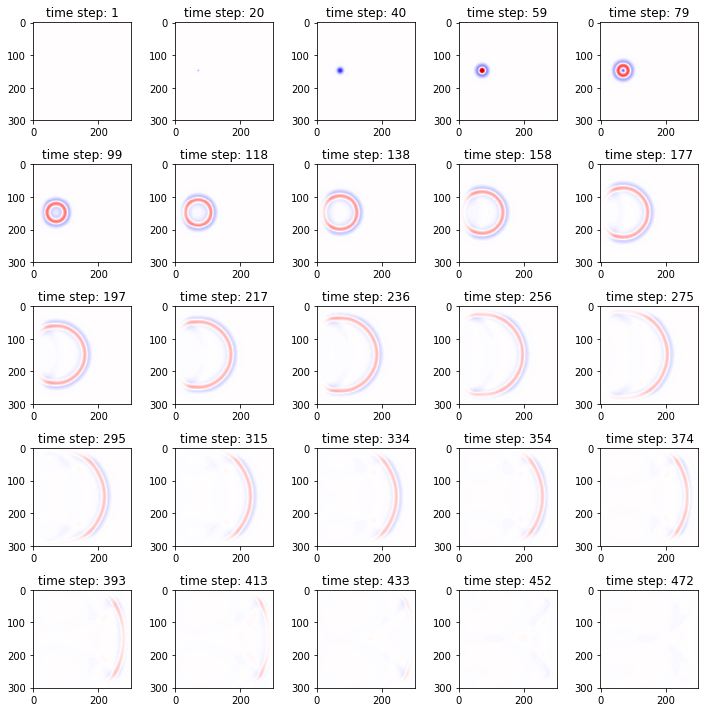

In [6]:
cols = 5
Nplots = 25
rows = Nplots // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

print(np.max(u.data))
print(np.min(u.data))
vmin = np.min(u.data) / 2
vmax = np.max(u.data) / 2
vmin = -1 * (max(abs(vmin), abs(vmax)))
vmax = -1 * vmin
for j in range(rows):
    axs = axes[j, :]
    for i, ax in enumerate(axs):
        idx = int(j * cols + i)
        ax.imshow(u.data[idx * u.shape[0] // Nplots + 1].T, cmap='seismic', vmin=vmin, vmax=vmax)
        ax.set_title("time step: {}".format(idx * u.shape[0] // Nplots + 1))


fig.tight_layout()
print(u.shape)

In [7]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict damp_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, const float s, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec, const int x_M, const int x_m, const int y_M, const int y_m, const float

In [6]:
dim = 2
shape = (201, 201)
# Spacing is in m, distance between grid points along an axis
spacing = (50, 50)
origin = (0, 0)
so, to = 2, 2
v_water = 1.500
v_rock = 2.000 # Could be upto 4.000 (salt closer to 5.000)
nbl = 50 # Number of boundary layers

def get_xymax(shape, nbl, spacing):
    return (shape[0]-1 + 2 * nbl) * spacing[0], (shape[1]-1 + 2 * nbl) * spacing[1]
# True xmax, ymax based on the grid
xmax, ymax = get_xymax(shape, nbl, spacing)
# xmax, ymax of the computational domain
comp_xmax, comp_ymax = (shape[0]-1) * spacing[0], (shape[1]-1) * spacing[1]

n_src, n_recv = 1, 5
src_coords, recv_coords = np.zeros((n_src, dim)), np.zeros((n_recv, dim))
# Put source vertically in the middle of the domain, and 10% away from the left edge of the computational domain
for k in range(n_src):
    src_coords[k] = [0.1 * comp_xmax, (k+1) * comp_ymax / (n_src+1)]
# src_coords[0] = [0.1 * comp_xmax, comp_ymax / 2]
print(src_coords)
# Put the receivers in a straight line along the right edge of the domain,
# about 10% away from the right edge of the computational domain
for k in range(n_recv):
    recv_coords[k] = [0.9 * comp_xmax, (0.1 + (1.0/n_recv) * k) * comp_ymax]

# Give initial velocity = v_water (km/s)
v_initial = np.ones(shape) * v_water
model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp')
# Uncomment to use non-uniform buoyancy
# Initial buoyancy
# b_initial = np.ones(shape)
# Set the right half of the domain to have a different buoyancy 
# b_initial[shape[0] // 2:, :] = 0.5
# model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp', b=b_initial)

# Set up time-partition
dt = model.critical_dt
t0 = 0
tn = 1e4
time_range = TimeAxis(start=t0, stop=tn, step=dt)
# Frequency kHz
f0 = 0.001

src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=n_src, time_range=time_range)
src.coordinates.data[:, :] = src_coords

rec = Receiver(name='rec', grid=model.grid, npoint=n_recv, time_range=time_range)
rec.coordinates.data[:, :] = recv_coords
# Set up functions for PDE
# m = 1 / v^2 = squared slowness
m = Function(name='m', grid=model.grid, space_order=so)
# u is our displacement field, save it at all time steps so we can plot later
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to, save=Buffer(time_range.num))
# Extract dimensions so we can do central differences
t = model.grid.time_dim
x, y = model.grid.dimensions

# b_dx = 0.5 * (model.b.dx(x0=x-x.spacing/2) + model.b.dx(x0=x+x.spacing/2))
# b_dy = 0.5 * (model.b.dy(x0=y-y.spacing/2) + model.b.dy(x0=y+y.spacing/2))
u_dx = 0.5 * (u.dx(x0=x-x.spacing/2) + u.dx(x0=x+x.spacing/2))
u_dy = 0.5 * (u.dy(x0=y-y.spacing/2) + u.dy(x0=y+y.spacing/2))

# Reference - https://github.com/devitocodes/devito/blob/45c75a7591e8f098c8b48c21ea639d5bf1bf368a/examples/seismic/acoustic/operators.py

pde = model.m * u.dt2 - u.laplace - dt**2 / 12 * u.biharmonic(model.m) + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
pde

[[1000. 5000.]]


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


damp(x, y)*Derivative(u(t, x, y), t) - 34.7140078142802*Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))/vp(x, y)**2, (x, 2)) - 34.7140078142802*Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))/vp(x, y)**2, (y, 2)) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [7]:
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + 34.7140078142802*Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))/vp(x, y)**2, (x, 2)) + 34.7140078142802*Derivative((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))/vp(x, y)**2, (y, 2)) + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [8]:
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m - src.laplace / 12 - dt**2 * src.dt2 / 12)
rec_term = rec.interpolate(expr=u.forward)
op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)

In [9]:
# print(op.ccode)
op(time=time_range.num-1, dt=model.critical_dt)

InvalidArgument: OOB detected due to time_M=490